In [31]:
# Basic libraries
import pandas as pd
import matplotlib.pyplot as plt

# Classification models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utilities and metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Exploração do Dataset

In [32]:
path = "../data/binary/"
df = pd.read_csv(path + 'WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [33]:
print(df.info())
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
label
1    37106
0    35028
Name: count, dtype: int64


## Preprocessamento do Dataset

In [34]:
df.dropna(inplace=True)
df = df.groupby('label').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)
df['label'].value_counts()

C:\Users\Rafael\AppData\Local\Temp\ipykernel_12260\2036060097.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)


label
1    3651
0    3503
Name: count, dtype: int64

## Divisão do Dataset em treino e teste

In [35]:
features = df['text']
target = df['label']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=421)

## Definição dos vetorizadores, modelos e parâmetros para o GridSearch

In [36]:
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer()
]

param_grids = [
    {
        'vectorizer': vectorizers,
        'classifier': [SVC()],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 1.0]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 150, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [1, 10],
        'classifier__penalty': ['l2']
    },
    {
        'vectorizer': vectorizers,
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7]
    },
    {
        'vectorizer': vectorizers,
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20]
    }
]

pipeline = Pipeline([
    ('vectorizer', 'passthrough'),
    ('classifier', 'passthrough')
])

## Execução do GridSearch

In [37]:
grid_search = GridSearchCV(pipeline, param_grids, cv=5, n_jobs=4, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', 'passthrough'),
                                       ('classifier', 'passthrough')]),
             n_jobs=4,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [1, 10],
                          'classifier__kernel': ['linear', 'rbf'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.01, 1.0],
                          'vectorizer': [TfidfVectoriz...
                          'classifier__penalty': ['l2'],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7],
                          'vectorizer': [TfidfVectorizer(), CountVectorizer()]},
                         {'classifier': [DecisionTreeClassifier()],
                          'classifier__max_depth': [None, 10, 20],
                          'vectorizer': [TfidfVectorizer(),
                                         CountVectorizer()]}],
             scoring='accuracy', verbose=2)

## Resultados finais e matriz de confusão

In [38]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest set classification report with best model:")
print(classification_report(y_test, y_pred, digits=4))

Best parameters found: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 1, 'classifier__penalty': 'l2', 'vectorizer': CountVectorizer()}
Best cross-validation score: 0.9250378660640669

Test set classification report with best model:
              precision    recall  f1-score   support

           0     0.9484    0.9173    0.9326       701
           1     0.9230    0.9521    0.9373       730

    accuracy                         0.9350      1431
   macro avg     0.9357    0.9347    0.9349      1431
weighted avg     0.9354    0.9350    0.9350      1431



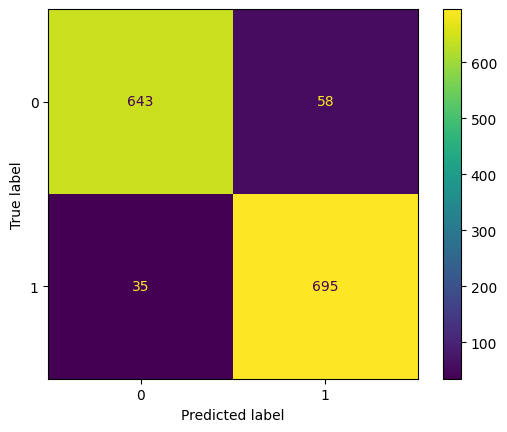

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis')